In [48]:
import pandas as pd
import sys
sys.path.append('../src') 
from data_loader import ChestXray8Dataset
from models.cnn import ResNet50
import time
import torch.optim as optim
import torch.nn as nn

import os
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Progession bar

# Configuration settings
data_dir = Path.cwd().parent / 'data'
images_dir = data_dir / 'images'
metadata_dir = data_dir /'metadata'/ 'Data_Entry_2017_v2020.csv'
train_list_path = data_dir /'metadata'/ 'train_val_list.txt'
test_list_path = data_dir / 'metadata' /'test_list.txt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
metadata_df = pd.read_csv(metadata_dir)
print(metadata_df)
print(type(metadata_df))

             Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_001.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0 

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import csv
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import random_split
import pandas as pd

# -----------------------------
# Definición de Focal Loss
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# -----------------------------
# Funciones de Métricas
# -----------------------------
def compute_metrics(outputs, labels):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    labels = labels.cpu().numpy()
    
    aucs = []
    f1s = []
    for i in range(outputs.shape[1]):  # Loop por clases
        try:
            auc = roc_auc_score(labels[:, i], outputs[:, i])
            f1 = f1_score(labels[:, i], outputs[:, i] > 0.5)
        except ValueError:
            auc, f1 = 0.0, 0.0
        aucs.append(auc)
        f1s.append(f1)
    return np.mean(aucs), np.mean(f1s)

def save_metrics(epoch, train_loss, val_loss, train_auc, val_auc, train_f1, val_f1, file_path):
    with open(file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        if epoch == 0:
            writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_AUC', 'Val_AUC', 'Train_F1', 'Val_F1'])
        writer.writerow([epoch + 1, train_loss, val_loss, train_auc, val_auc, train_f1, val_f1])

# -----------------------------
# Funciones de Entrenamiento y Validación
# -----------------------------
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_outputs.append(outputs)
        all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    avg_loss = running_loss / len(train_loader.dataset)
    auc, f1 = compute_metrics(all_outputs, all_labels)
    return avg_loss, auc, f1

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    avg_loss = running_loss / len(val_loader.dataset)
    auc, f1 = compute_metrics(all_outputs, all_labels)
    return avg_loss, auc, f1

# -----------------------------
# Configuración del Modelo
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset y loaders (ajusta tus rutas de archivos)
train_val_dataset = ChestXray8Dataset(
    img_dir=images_dir, 
    metadata_file=metadata_dir, 
    split_file=train_list_path,
    mode='train',  # Training mode
    transform=transform
)
test_dataset = ChestXray8Dataset(
    img_dir=images_dir, 
    metadata_file=metadata_dir, 
    split_file=test_list_path,
    mode='test',  # Training mode
    transform=transform
)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)  # 14 clases
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definición de Focal Loss
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# Entrenamiento del Modelo
# -----------------------------
num_epochs = 10
metrics_file = 'training_metrics_2.csv'

# Limpiar archivo previo
with open(metrics_file, 'w') as f:
    pass

for epoch in range(num_epochs):
    train_loss, train_auc, train_f1 = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc, val_f1 = validate_model(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    save_metrics(epoch, train_loss, val_loss, train_auc, val_auc, train_f1, val_f1, metrics_file)

# -----------------------------
# Evaluación en el Test Set
# -----------------------------
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    avg_loss = running_loss / len(test_loader.dataset)
    auc, f1 = compute_metrics(all_outputs, all_labels)
    return avg_loss, auc, f1

test_loss, test_auc, test_f1 = test_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | Test F1: {test_f1:.4f}")


Epoch 1/10 - Train Loss: 0.0447 | Val Loss: 0.0439 | Train AUC: 0.6292 | Val AUC: 0.6757 | Train F1: 0.0025 | Val F1: 0.0012
Epoch 2/10 - Train Loss: 0.0429 | Val Loss: 0.0428 | Train AUC: 0.6811 | Val AUC: 0.7045 | Train F1: 0.0107 | Val F1: 0.0047
Epoch 3/10 - Train Loss: 0.0420 | Val Loss: 0.0421 | Train AUC: 0.7058 | Val AUC: 0.7275 | Train F1: 0.0150 | Val F1: 0.0281
Epoch 4/10 - Train Loss: 0.0413 | Val Loss: 0.0412 | Train AUC: 0.7269 | Val AUC: 0.7479 | Train F1: 0.0173 | Val F1: 0.0060
Epoch 5/10 - Train Loss: 0.0405 | Val Loss: 0.0409 | Train AUC: 0.7492 | Val AUC: 0.7542 | Train F1: 0.0221 | Val F1: 0.0121
Epoch 6/10 - Train Loss: 0.0400 | Val Loss: 0.0397 | Train AUC: 0.7595 | Val AUC: 0.7658 | Train F1: 0.0294 | Val F1: 0.0193
Epoch 7/10 - Train Loss: 0.0395 | Val Loss: 0.0391 | Train AUC: 0.7722 | Val AUC: 0.7790 | Train F1: 0.0323 | Val F1: 0.0406
Epoch 8/10 - Train Loss: 0.0390 | Val Loss: 0.0391 | Train AUC: 0.7831 | Val AUC: 0.7810 | Train F1: 0.0386 | Val F1: 0.0427


In [51]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, device, threshold=0.5, class_names=None):
    model.eval()
    all_outputs = []
    all_labels = []

    # Obtener todas las predicciones y etiquetas
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.cpu().numpy()
            outputs = torch.sigmoid(model(inputs)).cpu().numpy()  # Aplicar Sigmoid

            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)

    # Aplicar el umbral para las etiquetas predichas
    preds = (all_outputs > threshold).astype(int)

    # Calcular la matriz de confusión para cada clase
    num_classes = all_labels.shape[1]
    fig, axes = plt.subplots(4, (num_classes // 4) + 1, figsize=(20, 15))  # Ajusta el tamaño si hay muchas clases
    axes = axes.ravel()

    for i in range(num_classes):
        cm = confusion_matrix(all_labels[:, i], preds[:, i])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Class: {class_names[i] if class_names else i}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")

    plt.tight_layout()
    plt.show()


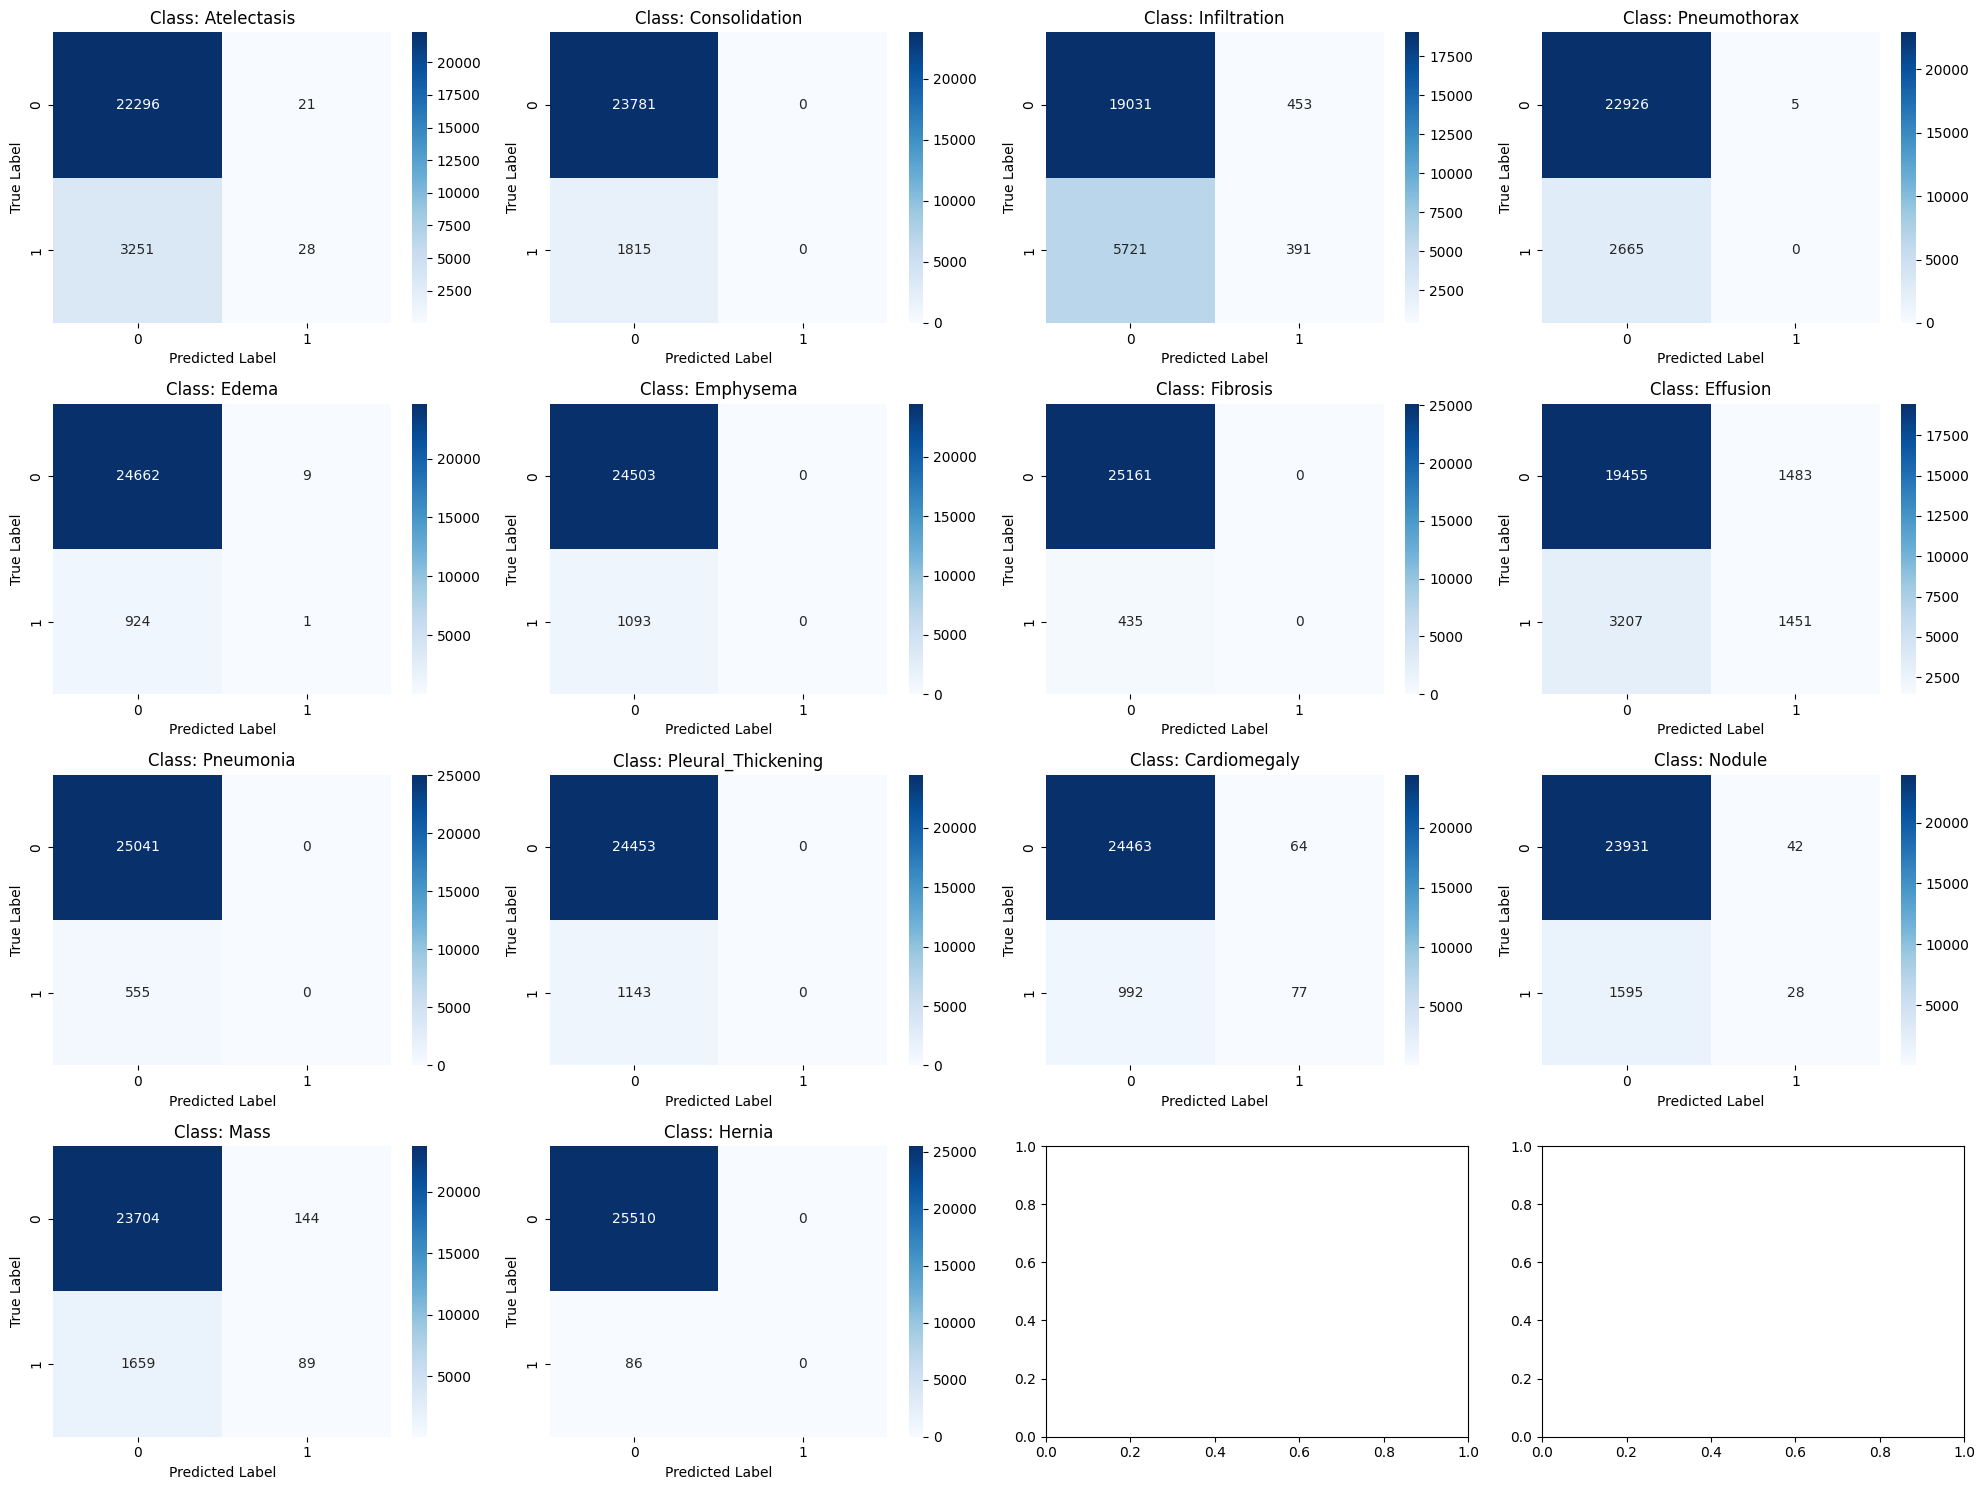

In [52]:
# Nombres de las clases (de tus etiquetas multiclase)
class_names = ["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", 
               "Edema", "Emphysema", "Fibrosis", "Effusion", 
               "Pneumonia", "Pleural_Thickening", "Cardiomegaly", 
               "Nodule", "Mass", "Hernia"]

# Llamar a la función
plot_confusion_matrix(model, test_loader, device, threshold=0.5, class_names=class_names)
